In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import cm
from matplotlib.lines import Line2D
from IPython.display import Image
#check version pandas

# Seaborn is a cool library to use whenever starting data exploration
%matplotlib inline

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 7, 7
plt.rc("font", size=14)


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

# Data exploration

## Table Of Content: <a class="anchor" id="toc"></a>

* [**Loading the data**](#loading)

* [**Clustering methods**](#fifth-bullet)
    * [K-means](#Kmeans-bullet)
    * [Hierarchichal clustering](#HC-bullet)
    

* [**Exercise: single cell RNAseq data**](#exo-kmeans-single)
* [**Additionnal exercise : mammal sleep data**](#exo-kmeans-mammals)


* [**Appendix**](#appendix-bullet)
    * [DBSCAN](#DBSCAN-bullet)
    * [Gaussian mixtures](#gm-bullet)
    


# Loading the data <a class="anchor" id="loading"></a>


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

df_im = pd.read_csv('../data/aaf2288-Table-S8.csv',header=0)

CD8_info = df_im["CD8+ T cell response induced in healthy donor: Tested/Observed"]
response = np.full(df_im.shape[0],"na")
response[CD8_info.notna() & CD8_info.str.contains("YES /")] = "ne"
response[CD8_info.notna() & CD8_info.str.contains("/ YES")] = "po"

df_im.loc[response=="po",'Mutant peptide'] = df_im.loc[response=="po",'Mutant peptide']+"*"

# select the numerical features
X_im = df_im[["Position of mutation in peptide","Predicted affinity wildtype peptide (nM)",
              "Predicted affinity mutant peptide (nM)","Predicted cleavage probability wildtype peptide",
              "Predicted cleavage probability mutant peptide","Predicted stability wildtype peptide (hours)",
              "Predicted stability mutant peptide (hours)","% of mutant reads","RNA expression of gene (FPKM)"]]

d = {"Position of mutation in peptide":"MUT_pos",
     "Predicted affinity wildtype peptide (nM)":"WT_affin",
     "Predicted affinity mutant peptide (nM)":"MUT_affin",
     "Predicted cleavage probability wildtype peptide":"WT_cleav",
     "Predicted cleavage probability mutant peptide":"MUT_cleav",
     "Predicted stability wildtype peptide (hours)":"WT_stability",
     "Predicted stability mutant peptide (hours)":"MUT_stability",
     "% of mutant reads":"WT_read_perc",
     "RNA expression of gene (FPKM)":"RNA_expr"}

X_im = X_im.rename(columns = d, inplace = False) # rename the columns
# some features have highly skewed distributions and its better to normalize them by a log-transform
X_im['RNA_expr'] = np.log10(X_im['RNA_expr'])
X_im['WT_affin'] = np.log10(X_im['WT_affin'])
X_im['MUT_affin'] = np.log10(X_im['MUT_affin'])

# select the numerical features

X_im = X_im.set_index(df_im['Mutant peptide'], inplace=False)

X_im_num = X_im.copy()
X_im['Response'] = response
X_im.reset_index()



# scaling 
scaler = StandardScaler()
X_im_scaled = scaler.fit_transform(X_im_num)

# PCA 
X_im_pca = PCA().fit_transform(X_im_scaled)

# tsne
X_im_tsne=TSNE(n_components=2,perplexity=100).fit(X_im_scaled)#create the T-SNE object and fit the data

In [3]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

iris = load_iris()

X_iris = pd.DataFrame(iris['data'],columns=iris['feature_names'])

X_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


explained variance with 2 comonents: 95.81%


Text(0, 0.5, 'Second Principal Component (22.85%)')

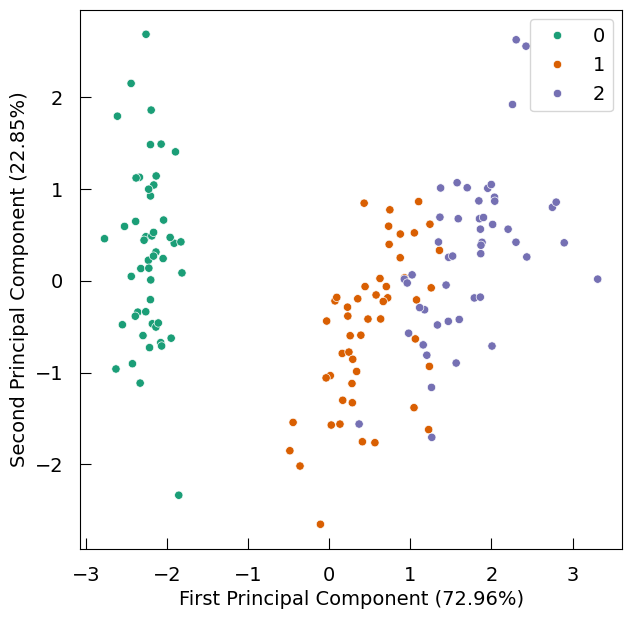

In [4]:

X_iris_scaled = StandardScaler().fit_transform( X_iris )

pca = PCA(n_components=2) #create an empty PCA object
X_iris_pca = pca.fit_transform(X_iris_scaled)


print("explained variance with 2 comonents: {:.2f}%".format(100* sum(pca.explained_variance_ratio_) ) )
sns.scatterplot(x=X_iris_pca[:,0],y=X_iris_pca[:,1],hue = iris['target'] , palette = ['#1b9e77','#d95f02','#7570b3'])
plt.xlabel('First Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Second Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))

# Clustering <a class="anchor" id="fifth-bullet"></a>


Clustering is an unsupervised method that serves many puposes:

<ol>
<li>Pattern detection: discover hidden patterns in your data</li>
<li>Compression: replace all cluster members by one representive</li>
<li>Data augmentation: replace noisy feature vectors by the cluster consensus vector</li>
<li>Dimensionality reduction: replace a feature vector by cluster similarities</li>
<li>Outlier detection: detect feature vectors far away from cluster centers</li>
<li>Semisupervised learning: assign cluster labels to unlabeled cluster members</li>
<li>...</li>
</ol>

If you find some cluster-like structures in your data and if they correspond to one of your hypothesis then you already came a long way. Rarely you can get there in one step, but you need to carefully clean and normalize your data to discover these structures. Be aware that clustering algorithms are not magical techniques that give you a straight answer: you will need to find good hyperparameters for the model to work, and your expertise and understanding of the data is crutial to obtain good results.

[Back to ToC](#toc) 

## K-means clustering <a class="anchor" id="Kmeans-bullet"></a>

The [K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) algorithm is a widely used clustering algorithm. The K-means algorithm aims at finding the right partition of the data ($\pmb{X_1},...,\pmb{X_n}$) into $K$ clusters $\pmb{C}={C_1,...,C_K}$ so that the within cluster sum of squares (inertia) is minimized:

$\pmb{C}=argmin_{\pmb{C}} \sum_{k=1}^{K}\sum_{i \in C_k}||\pmb{X_i}-\pmb{\mu_k}||^2$

$\pmb{\mu_k}=\frac{1}{|C_k|}\sum_{i \in C_k}\pmb{X_i}$

K-means requires the number of clusters as input. The greedy algorithm consists of 3 main parts:
<ol>
<li>Choose $K$ points from $\pmb{X_i}$ as initial values for $\pmb{\mu_k}$. These initial points should be spread out over the dataset</li>
<li>Compute the centroids $\pmb{\mu_k}=\frac{1}{|C_k|}\sum_{i \in C_k}\pmb{X_i}$</li>
<li>Assignment step: assign each $\pmb{X_i}$ to a cluster $C_k=argmin_{C_k} ||\pmb{X_i}-\pmb{\mu_k}||^2$ </li>
<li>Update step: recalculate $\pmb{\mu_k}=\frac{1}{|C_k|}\sum_{i \in C_k}\pmb{X_i}$</li>
<li>Iterate steps 3 & 4 until convergence</li>
</ol>

<!-- ![km1](../images/Kmeans1.png) -->

<!-- ![km2](../images/Kmeans2.png) -->

In [5]:
from scipy.spatial.distance import cdist
# the following code is inpired from https://mlcourse.ai/book/topic07/topic7_pca_clustering.html

def Kmean_plot( X , clusters , centroids=None , ax = None):
    palette = ['xkcd:brick','xkcd:orange','xkcd:pink','xkcd:silver','xkcd:mustard','xkcd:black'][:len( set(clusters) )]
    sns.scatterplot(x=X.iloc[:,0],y=X.iloc[:,1],
                    hue = clusters , palette = palette,alpha = 0.5 , ax=ax , legend=False)
    if not centroids is None:
        sns.scatterplot(x=centroids[:,0],
                y=centroids[:,1],
                hue = np.arange(centroids.shape[0]), palette = palette , 
                        s = 300 , marker = 'X' , legend = False , ax=ax)




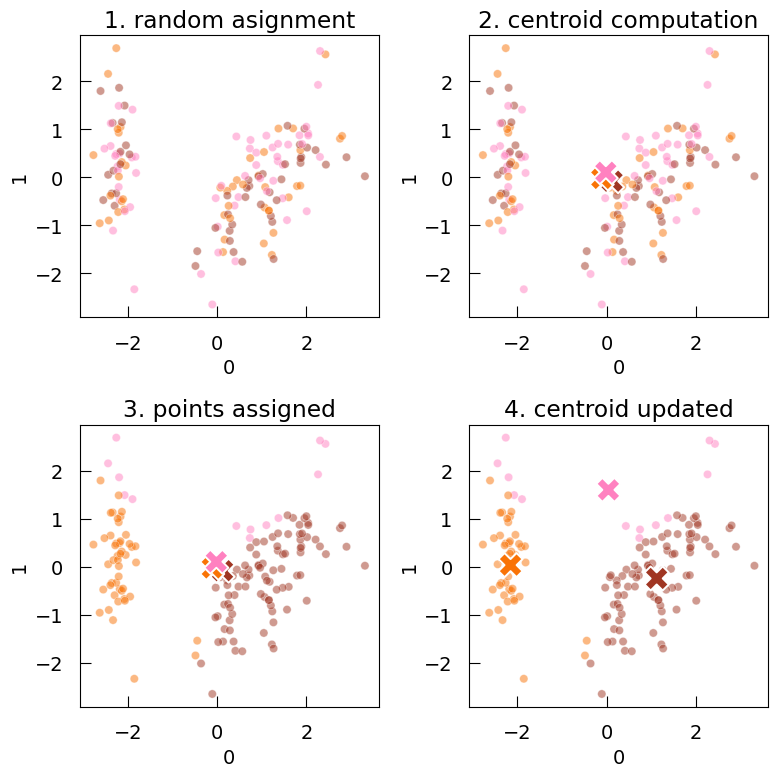

In [6]:
df_iris_pca = pd.DataFrame( X_iris_pca )

K = 3
n = X_iris_pca.shape[0]

fig,ax = plt.subplots( 2,2 , figsize = (8,8) )



## 1. initialization : randomly assign clusters
cluster_assignment = np.random.choice(K , n)

Kmean_plot( df_iris_pca , cluster_assignment , centroids=None , ax = ax[0,0])
ax[0,0].set_title( "1. random asignment" )

## 2. compute the centroids of each created cluster
df_centroids = np.array( df_iris_pca.groupby(cluster_assignment).mean() )

Kmean_plot( df_iris_pca , cluster_assignment , centroids=df_centroids , ax = ax[0,1])
ax[0,1].set_title( "2. centroid computation" )

## 3. re-assign each point according ot the closest centroid
distances = cdist(df_iris_pca , df_centroids)
cluster_assignment = distances.argmin( axis = 1 )

Kmean_plot( df_iris_pca , cluster_assignment , centroids=df_centroids , ax = ax[1,0])
ax[1,0].set_title( "3. points assigned" )


## 4. re-compute the centroids of each created cluster
df_centroids = np.array( df_iris_pca.groupby(cluster_assignment).mean() )

Kmean_plot( df_iris_pca , cluster_assignment , centroids=df_centroids , ax = ax[1,1])
ax[1,1].set_title( "4. centroid updated" )

plt.tight_layout()

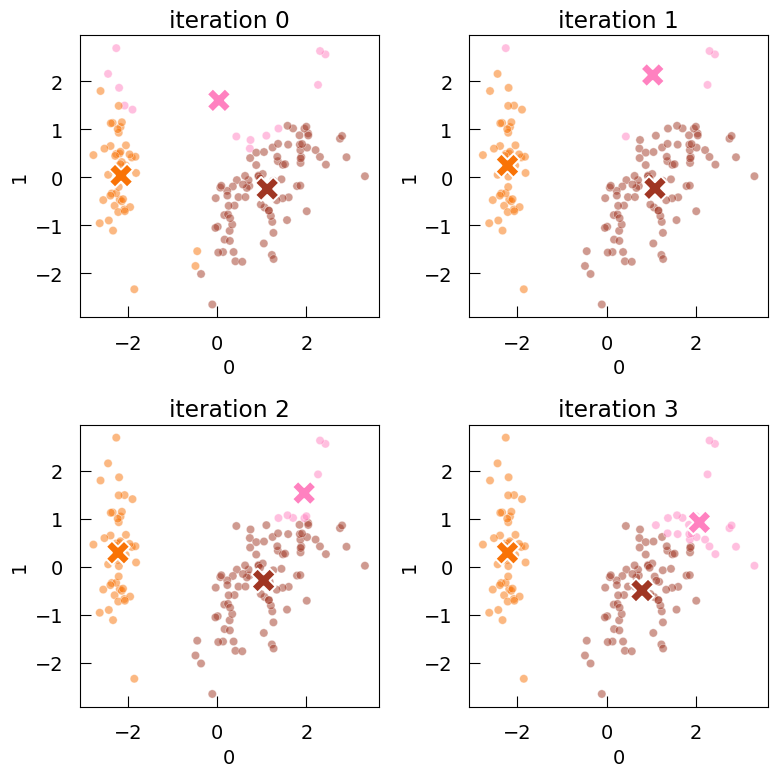

In [7]:
fig,ax = plt.subplots( 2,2 , figsize = (8,8) )
Kmean_plot( df_iris_pca , cluster_assignment , centroids=df_centroids , ax = ax[0,0])
ax[0,0].set_title('iteration 0')

for i in range( 1,4 ):
    ## 3. re-assign each point according ot the closest centroid
    distances = cdist(df_iris_pca , df_centroids)
    cluster_assignment = distances.argmin( axis = 1 )

    ## 4. re-compute the centroids of each created cluster
    df_centroids = np.array( df_iris_pca.groupby(cluster_assignment).mean() )

    Kmean_plot( df_iris_pca , cluster_assignment , centroids=df_centroids , ax = ax[i//2,i%2])
    ax[i//2,i%2].set_title(f'iteration {i}')
plt.tight_layout()

For data with a cluster structure K-means complexity is often linear in the number of datapoints $\pmb{X_i}$ and it requires little additional memory. The data can be split into different chunks and the algo still works. Faster versions of the basic algorithm are available, e.g. [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans). This makes it an attractive algorithm for very large datasets.

K-means is a greedy algorithm, i.e. it will only find a local minimum of the inertia. 
Therefore it is good practice to run the algorithm several times with different initialization.

In `sklearn`, the [Kmeans implementation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) uses a *smart* intialization strategy (default), or a random initialization.

The number of differen initialization is controled with the `n_init` parameter (10 when initialization is random).


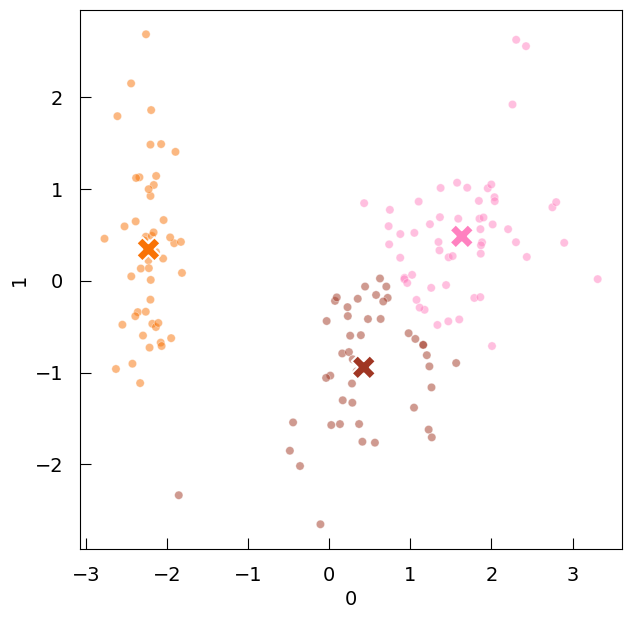

In [8]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 3)

km.fit( df_iris_pca ) ## k-means++ init, runs up to 300 iterations
Kmean_plot( df_iris_pca , km.labels_ , km.cluster_centers_)

**Important remarks:**

 - KMeans is based on a concept of distances : your **data needs to be properly scaled**
 - KMeans creates, by construction, **globular clusters**
 - KMeans results depends on parameter **K**


What values should we give to parameter K?

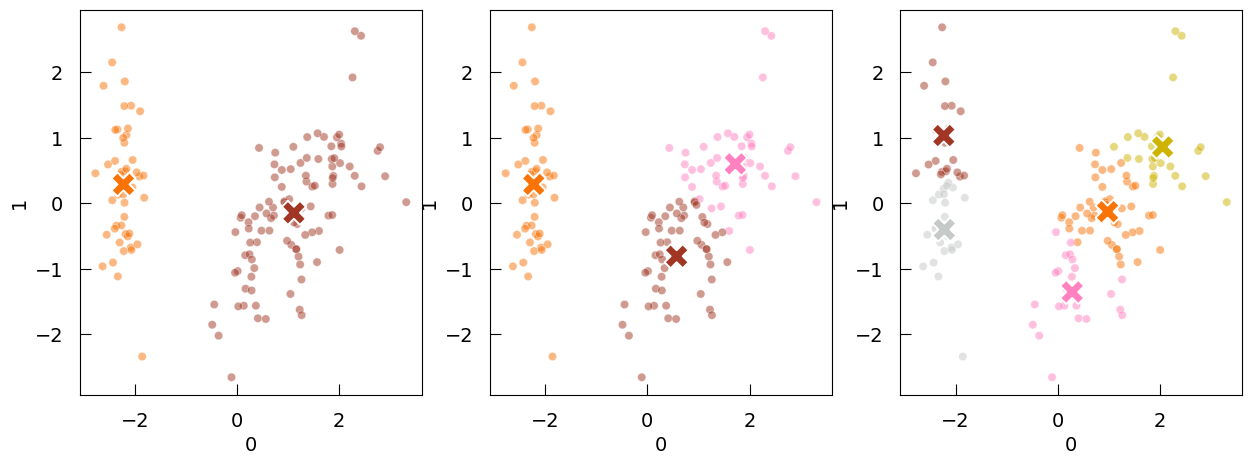

In [9]:
fig,ax = plt.subplots( 1,3 , figsize = (15,5) )
for i,K in enumerate( [2,3,5] ):
    km = KMeans(n_clusters = K)
    km.fit( df_iris_pca ) ## k-means++ init, runs up to 300 iterations
    Kmean_plot( df_iris_pca , km.labels_ , km.cluster_centers_, ax =ax[i])

We see that the number of clusters defines the k-means clustering outcome. It is difficult to say by looking at the t-SNE projections, whether 2 or 3 clusters better reveal underlying patterns of the data. 

There, we can compare the clustering proposed by different values of K with some of the clustering quality metrics provided by [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics). 
 
---
 
In one case, we could **use known categories**, like the species for the iris example, when they exists AND when we think they should form meaningful clusters.

An eample of such metric is the **Adjusted Rand Index** (ARI) which computes the similarity between two cluster assignments.

The unadjusted version is computed with:
 * $s$ : the number of pairs of objects which have the same cluster in clustering 1 and the same in clustering 2 too
 * $d$ : the number of pairs of objects which have different clusters in clustering 1 and different clusters in clustering 2 too
 * $p$ : the total number of possible pairs of objects

$$RI = \frac{s+d}{p}$$

The "Adjusted" version corresponds to a normalization that ensures that random clusterings give a value close to 0 and perfectly concordant clusterings a value of 1.


In [10]:
## ARI example
from sklearn.metrics import rand_score , adjusted_rand_score
labels_true = [ 0, 0 , 1 , 1 , 1 , 0 , 0 ] 
labels_pred = [ 0, 1 , 0 , 1 , 1 , 0 , 0 ] 

##   possible pairs of objects : (0,1) (0,2) (1,2)  ...
## in clustering 1             :   s     d     d    ...
## in clustering 2             :   d     s     d    ...
##                                             ^ this one is different in both clusterings 

print("RI: ", rand_score(labels_true, labels_pred))
print("ARI:", adjusted_rand_score(labels_true, labels_pred))

RI:  0.5238095238095238
ARI: 0.027777777777777776


---

Another way, in the more common case where we do not know the categories in advances would be to use some metric which **computes how each cluster is cohesive and well separated from the others**.

Here we will use the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) metric: 

The **silhouette score** is **calculated for each point** using 

* the mean intra-cluster distance : $a$
* the distance between a sample and the nearest cluster that the sample is not a part of : $b$


The Silhouette score for a single point is $SC=\frac{(b-a)}{max(a,b)}$

The sklearn function `silhouette_score` (from `sklearn.metrics`) returns the mean Silhouette score over all samples for a given clustering result. To obtain the values for each sample, use `silhouette_samples`.

$SC$ is always between -1 (bad clustering) and 1 (perfect clustering).

![silhouette illustration](../images/silhouette.png)

So the **silhouette score should be maximized.**

> Warning : some score should be maximized and some other minimized. Be sure you know which one it should be before interpreting your results!

--- 
Let's try to apply this logic to the iris data-set


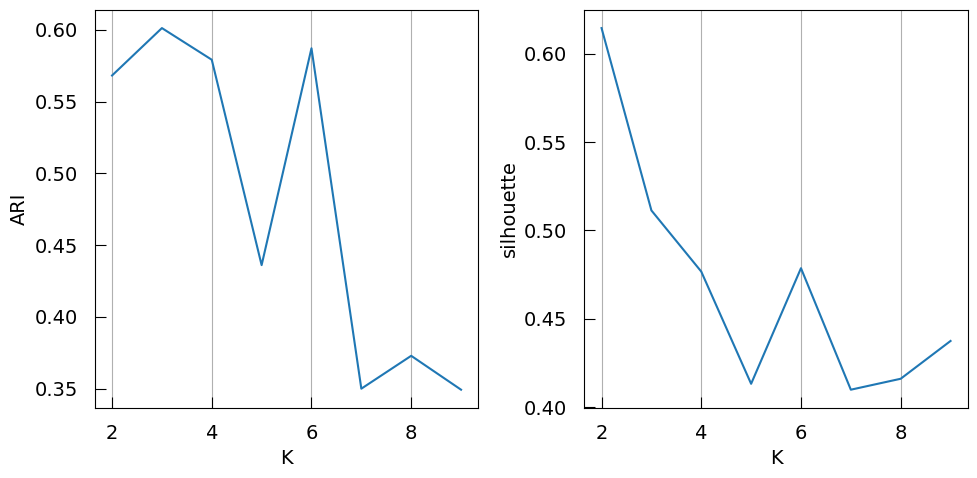

In [11]:
from sklearn.metrics import silhouette_score

ARIs = []
silhouettes = []

Ks = range( 2,10 )
for i,K in enumerate( Ks ):
    km = KMeans(n_clusters = K)
    km.fit( df_iris_pca ) 
    
    ## computing ARI and silhouette
    ARIs.append(        adjusted_rand_score(iris['target'], km.labels_) )
    silhouettes.append( silhouette_score( df_iris_pca , km.labels_ )    )
    

fig,ax = plt.subplots( 1,2 , figsize = (10,5) )
ax[0].plot( Ks, ARIs )
ax[0].set_ylabel('ARI')
ax[0].set_xlabel('K')
ax[0].grid(axis = 'x')
ax[1].plot( Ks, silhouettes )
ax[1].set_ylabel('silhouette')
ax[1].set_xlabel('K')
ax[1].grid(axis = 'x')
plt.tight_layout()

**Question:** What is the best K according to each metric ? Which one would you choose ?

remember, the data looks like this:

<Axes: >

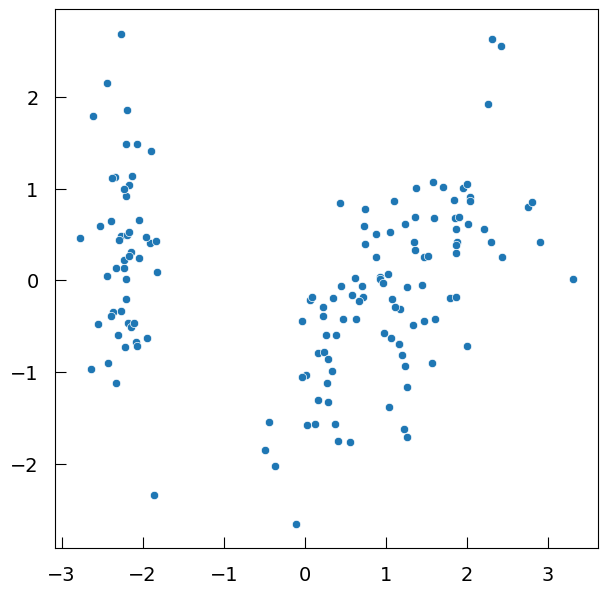

In [12]:
sns.scatterplot(x=X_iris_pca[:,0],y=X_iris_pca[:,1] )#,hue = iris['target'] , palette = ['#1b9e77','#d95f02','#7570b3'])

### Micro-exercise: Kmeans

Perform a kmean clustering on the AML data. What is the best number of clusters ? Does it looks like it correlates with the auc metric ?


In [13]:
df_aml=pd.read_excel('../data/gene_drug_sens.xlsx')
X_aml=df_aml[df_aml.columns[9:]] 

# df_aml.auc <-- this is the target metric
X_aml.head()

,CD86,FAM49A,ERMN,CHD5,RP11-333E13.2,KLHDC3,HNMT,ADAP2,B3GNT2,RP11-196G18.24,TLR2,MIR223,RAB43P1,GYPC,HSD17B13,HNRNPA1,NAPSB
0,-1.120073,-0.148654,-1.579624,-0.756073,0.471452,1.068268,-0.157964,-1.001751,1.556003,-1.608982,0.751515,0.987769,0.232332,0.981147,-2.021119,-1.185687,-0.710025
1,2.498957,-1.015880,-0.859471,-0.555560,-0.142550,-0.161521,2.279642,-0.933841,-0.189892,0.313041,2.097701,-1.627445,-0.961402,-0.523684,0.255906,0.885343,0.900553
2,0.176687,-0.490400,-0.611194,-0.443875,0.876031,-0.147330,0.112438,-0.185127,0.235198,-1.389968,0.007096,1.291810,-0.504791,0.813038,-0.741312,-1.180863,-2.541507
3,0.918236,0.377131,-0.410336,-0.033461,-0.014791,1.218267,1.122505,-0.333728,0.038227,-0.187054,-0.376509,0.826023,0.847269,-0.466044,0.374157,0.585562,-0.747859
4,-1.004299,-0.826399,0.995739,-1.426430,-0.053345,0.585897,-0.876732,0.564804,-0.835560,-0.566891,0.546441,-0.371254,1.609191,0.220240,-2.180800,1.076900,0.411095


Text(0, 0.5, 'Second Principal Component (8.33%)')

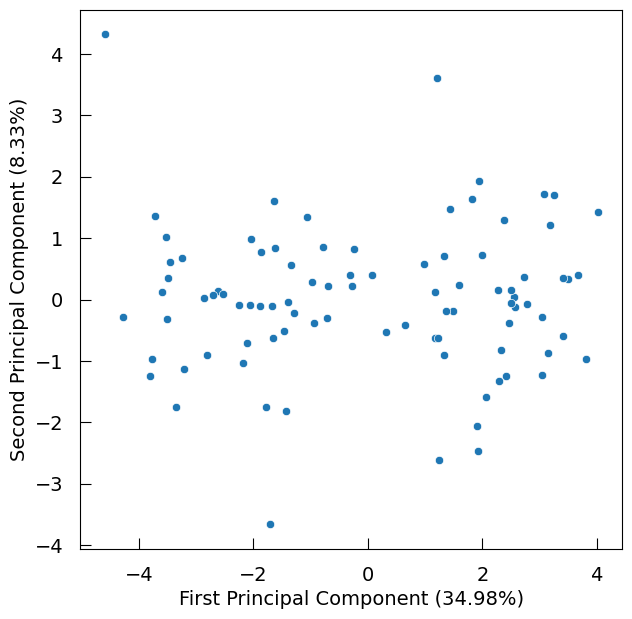

In [14]:
## The data is considered to be already properly normalized
X_aml_pca = pca.fit_transform(X_aml) 
sns.scatterplot( x = X_aml_pca[:,0] , y = X_aml_pca[:,1])
plt.xlabel('First Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Second Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))

[Back to ToC](#toc)

## Hierarchical clustering <a class="anchor" id="HC-bullet"></a>

Hierarchical clustering is an algorithms that iteratively merges data points or groups of data points. It starts with $N$ clusters, one cluster per data point. It first calculates the pairwise distances between all clusters. It then selects the two closests clusters and merges them into a new cluster. Next it recalculates the distances between the newly formed cluster and the remaining clusters. It repeats these steps until a specified number of clusters is reached or until all distances between clusters are larger than a specified threshold.

![HC](../images/Hierachi.png)

Since this type of algorithm requires pairwise distance calculations and does this up to $N$ times until all clusters are merged, the complexity of the algorithms is $N^3$. This is often too slow for large datasets. The algorithms can be accelarated by speeding up disnace calculations or initialize the clusters with a coarse k-means clustering.

The main advantage of the algorithm is the visualization of the results as dendograms and the easy interpretability of the results.

AgglomerativeClustering proposes a number of options regarding how to compute the similarity between clusters: the `linkage` option:

* `ward` minimizes the variance of the clusters being merged.
* `average` uses the average of the distances of each observation of the two sets.
* `complete` or maximum linkage uses the maximum distance between all observations of the two sets.
* `single` uses the minimum of the distances between all observations of the two sets.

Take a moment to think on the implication these choice of linkage could have when clustering.


In [15]:
# we use the scipy [dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) function to plot the corresponding dendrogram.
# adapter function from 
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
# to plot the dendrogram that will be explained below
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, label_colors = None , **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    R = dendrogram(linkage_matrix, **kwargs)
    
    ## coloring the labels
    if not label_colors is None:
        lbls = kwargs['ax'].get_xmajorticklabels()
        if kwargs.get('orientation','bottom') in ['left','right']:
            lbls = kwargs['ax'].get_ymajorticklabels()
            for i,lbl in enumerate( lbls ):
                color = label_colors[ R['leaves'][i] ]
                lbl.set_color( color )


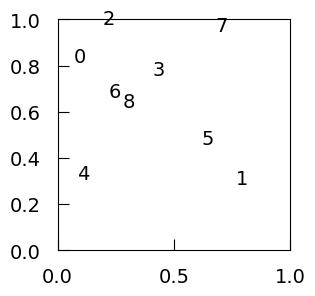

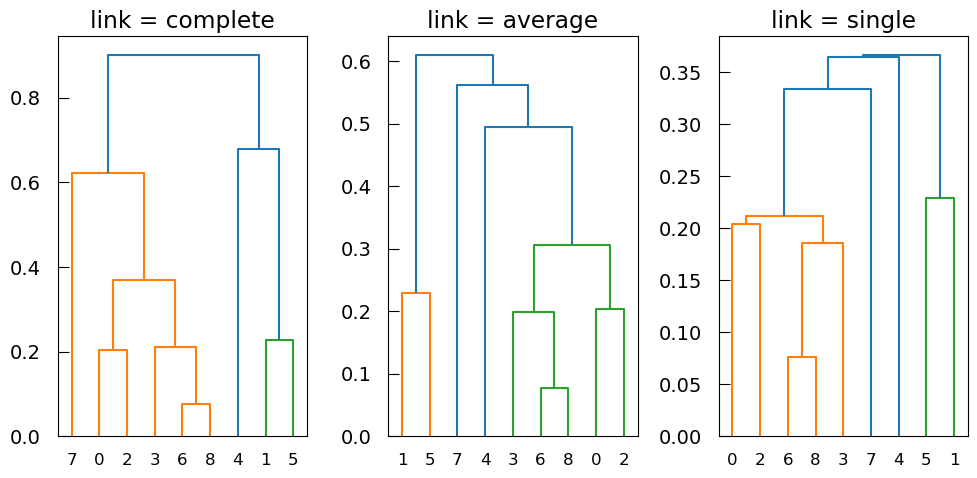

In [16]:
from sklearn.cluster import AgglomerativeClustering

## generating some random data
N = 9 
np.random.seed(4321)# 1234 is also nice 
x = np.random.random((N,2))

# try different linkages:
#    average : uses the average of the distances of each observation of the two sets.
#    complete : or maximum linkage uses the maximum distance between all observations of the two sets.
#    single : uses the minimum of the distances between all observations of the two sets.



fig,ax = plt.subplots( 1 , 1 , figsize=(3, 3))
for i in range(N):
    ax.text(x[i,0] , x[i,1] , str(i) )

fig,ax = plt.subplots( 1 , 3 , figsize=(10, 5))
for i,link in enumerate(['complete' , 'average' , 'single']):
    hclust = AgglomerativeClustering(n_clusters=None,distance_threshold=0, linkage=link)
    hclust.fit(x)
    
    plot_dendrogram( hclust , ax=ax[i])
    ax[i].set_title("link = "+link)
plt.tight_layout()

let's apply this on the iris dataset

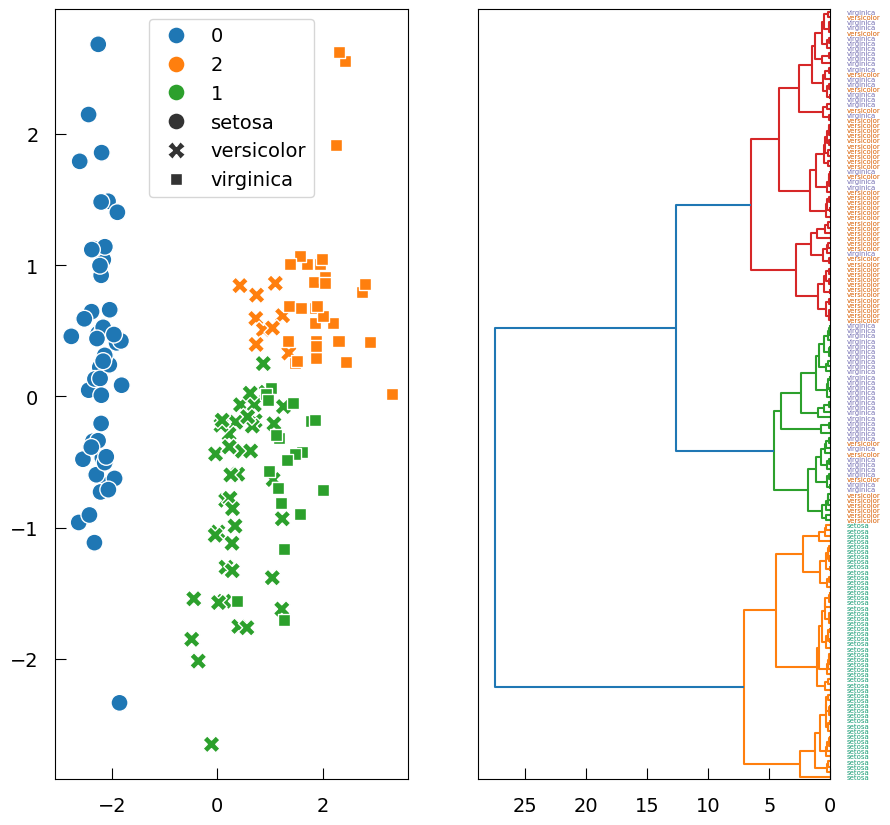

In [19]:

hclust = AgglomerativeClustering(n_clusters=3 , compute_distances=True)
hclust.fit(X_iris_pca)

fig,ax = plt.subplots( 1,2 , figsize = (10,10) )
sns.scatterplot(x=X_iris_pca[:,0],y=X_iris_pca[:,1] , hue = hclust.labels_.astype(str), s= 150,
                style = iris.target_names[iris['target']], ax=ax[0])
plot_dendrogram( hclust , 
                 color_threshold=10,
                 labels= iris.target_names[iris['target']],  
                 label_colors = np.array(['#1b9e77','#d95f02','#7570b3'])[ iris['target'] ],
                 orientation='left',leaf_font_size=5,
                 ax=ax[1])

Counter({np.int64(0): 949, np.int64(1): 85})


Text(0.5, 1.0, 'AgglomerativeClustering(n_clusters=2, linkage="ward")')

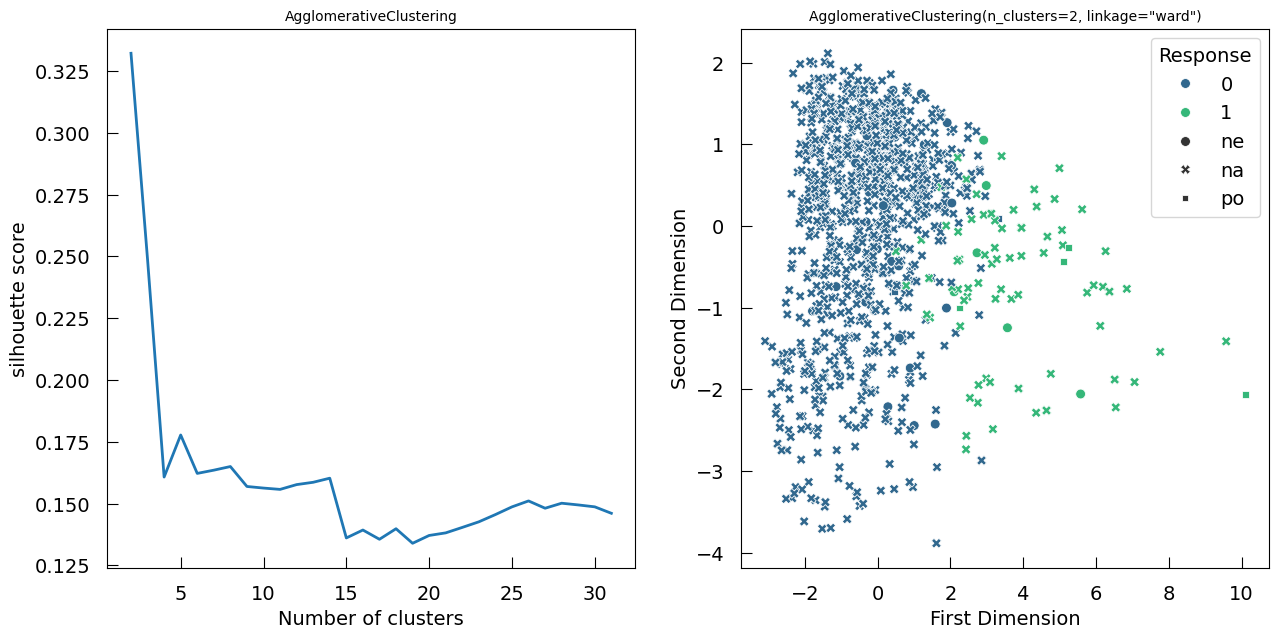

In [20]:
from collections import Counter

link = 'ward'
## we go from 2 to 32 clusters 
nr_clusters = np.arange(2,32)

scores = []
labels = []

for n in nr_clusters:
    hclust = AgglomerativeClustering(n_clusters=n, linkage=link)
    hclust.fit(X_im_pca)
    
    scores.append(silhouette_score(X_im_pca,hclust.labels_) )
    labels.append(hclust.labels_)

    
best_idx = np.argmax( scores )
best_labels = labels[best_idx]
best_score = scores[best_idx]
best_nr_clusters = nr_clusters[best_idx]

## report and plot

print(Counter(best_labels))
fig,ax = plt.subplots(1,2,figsize=(15,7))



ax[0].plot(nr_clusters, scores, ls="-", lw=2)
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('silhouette score')
ax[0].set_title('AgglomerativeClustering',fontsize=10)


sns.scatterplot( x = X_im_pca[:,0],y = X_im_pca[:,1],
                hue=best_labels,style = X_im.Response,
                s=50,palette='viridis', ax =ax[1])
ax[1].set_xlabel('First Dimension')
ax[1].set_ylabel('Second Dimension')
ax[1].set_title('AgglomerativeClustering(n_clusters={0}, linkage="{1}")'.format(best_nr_clusters,link),fontsize=10)


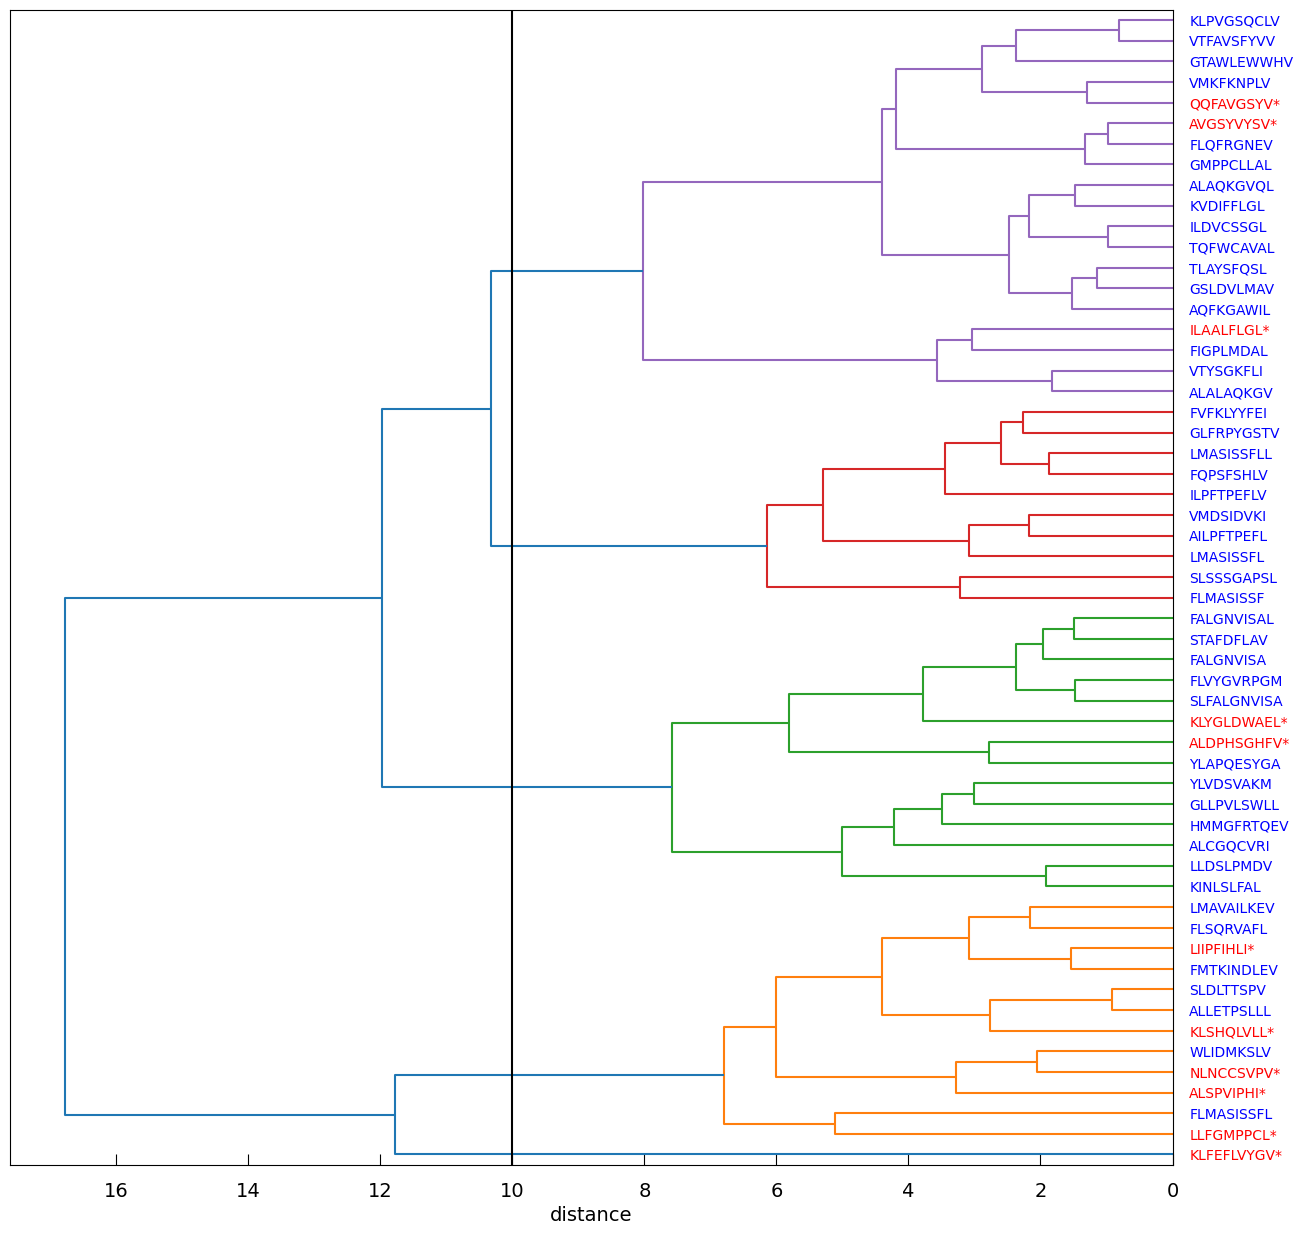

In [21]:

dendro = AgglomerativeClustering(n_clusters=None,distance_threshold=0, linkage='ward')
dendro.fit(X_im_pca[X_im['Response']!="na"])


fig,ax = plt.subplots(figsize=(15,15))

col_array = X_im.Response.map({'na':'grey','po':'red','ne':'blue'}).to_numpy()[X_im['Response']!='na']

plot_dendrogram(dendro,
                color_threshold=10,
                labels=X_im[X_im['Response']!="na"].index, 
                label_colors = col_array,
                orientation='left',leaf_font_size=10 , ax =ax)

ax.set_xlabel("distance")
ax.axvline(10, color='black')


The dendogram is the representation of the effect of your-cut off to define a cluster. For example if you decide that your threshold is going to be 15 : then you only have two clusters. If you change it to 11 you will have 4 clusters. If you put it to 0 : each point is a cluster!

---

Last but not least, hierarchical clustering is very common in **heatmaps**:

<Figure size 2000x3000 with 0 Axes>

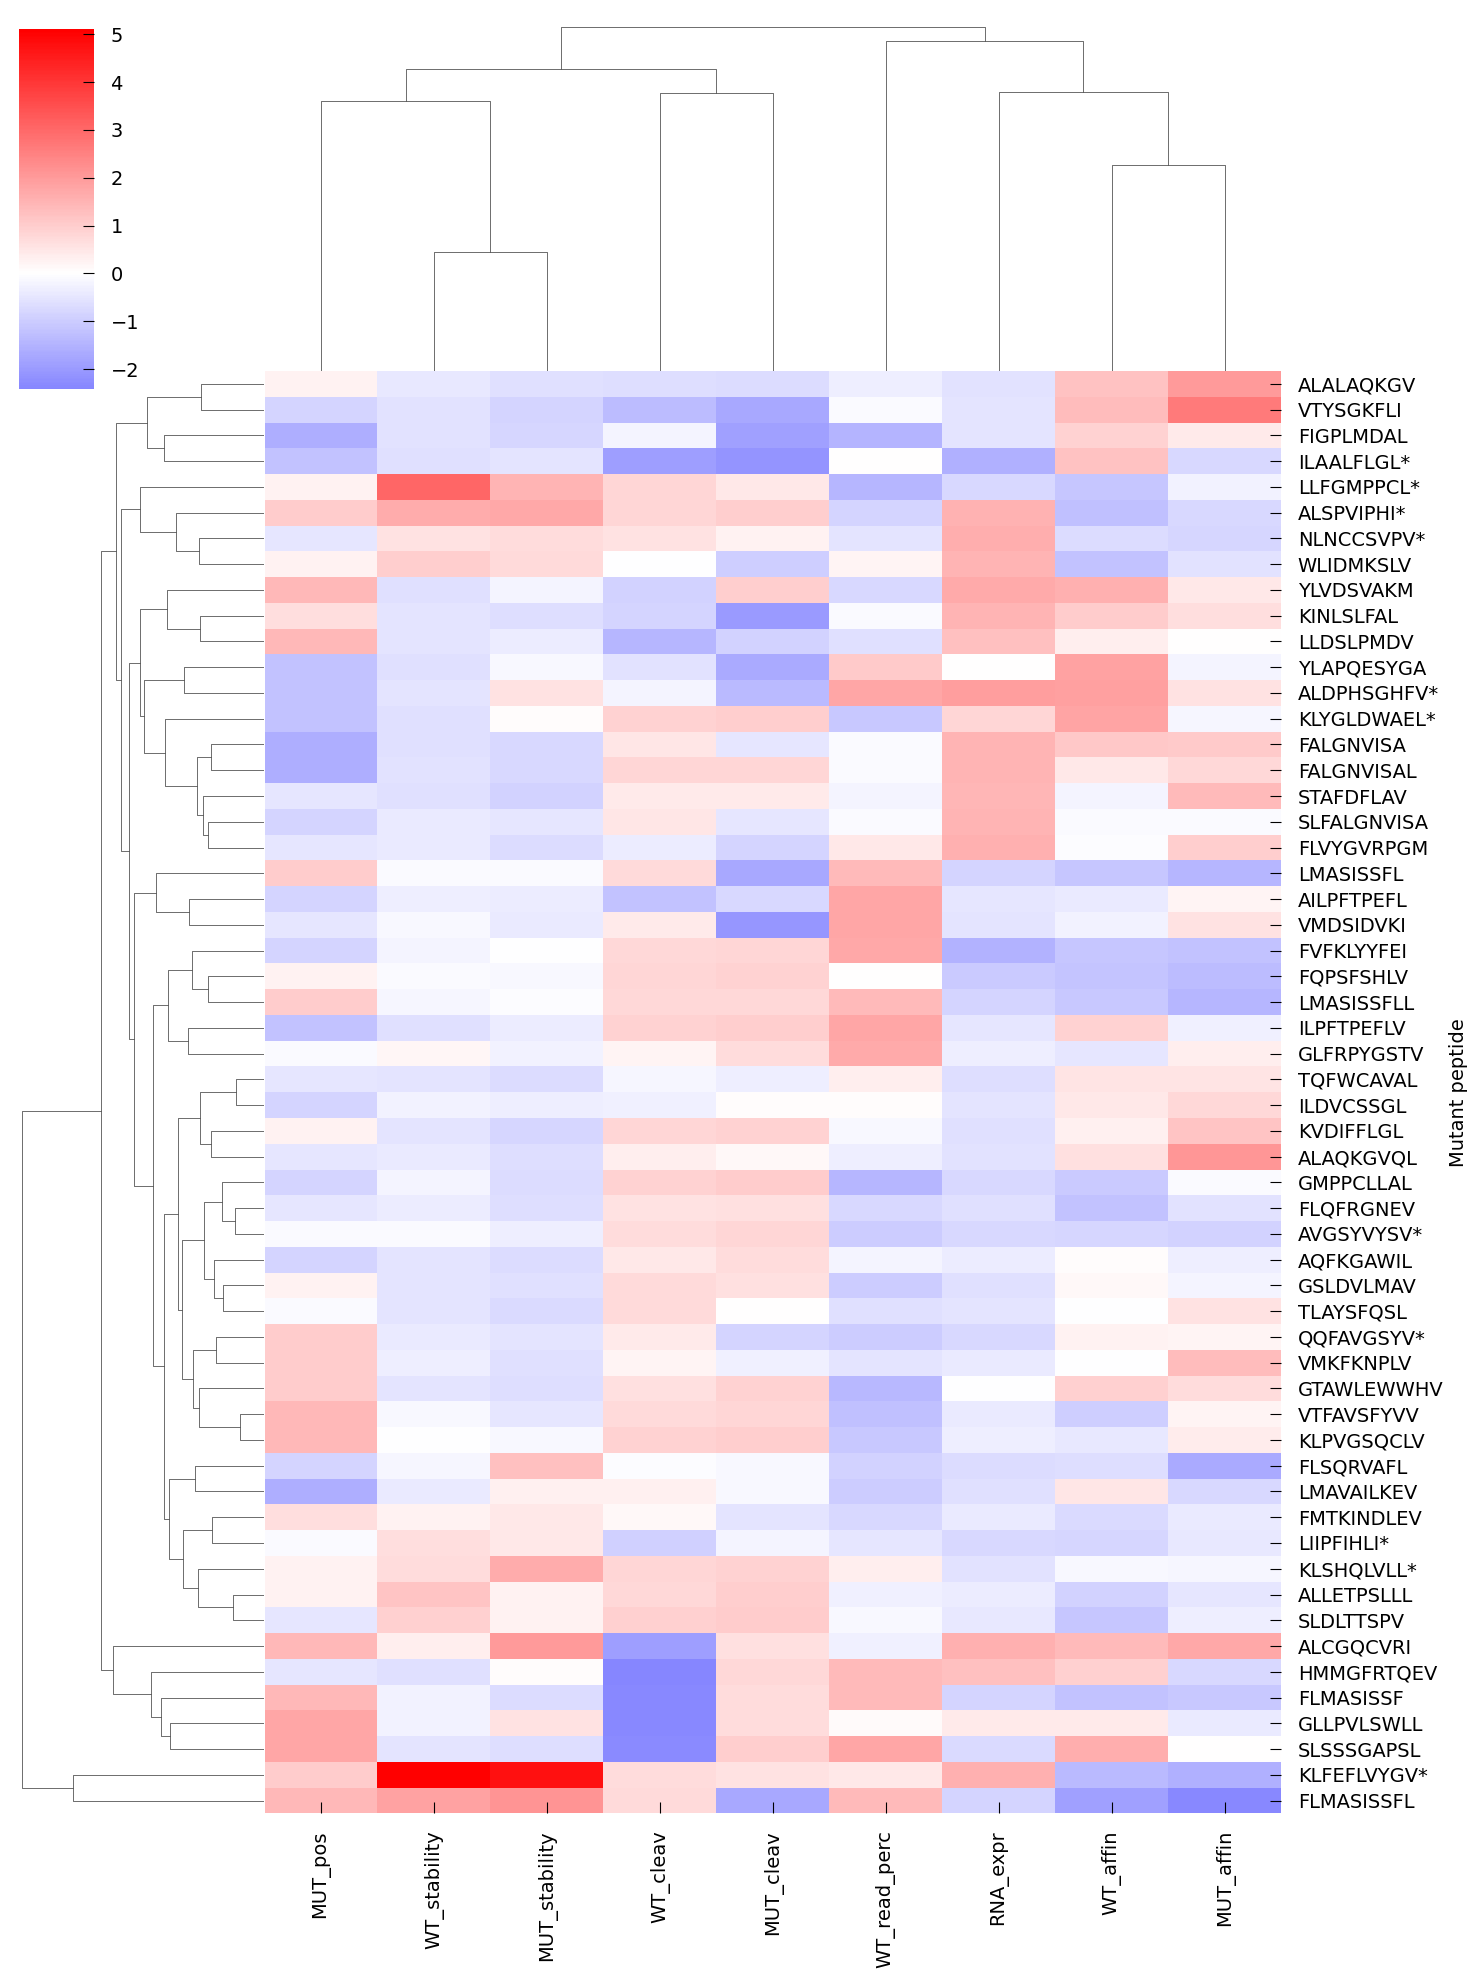

In [22]:
plt.figure(figsize=(20,30))
sns.clustermap(X_im_num[X_im['Response']!="na"],z_score=1,figsize=(15,20),cmap='bwr', center=0)
plt.show()

[Back to ToC](#toc)

## What is the best method for clustering ? <a id='best'></a>

As you surely suspect by now, there is no perfect method. 
Each algorithm makes different assumptions about the structure of your data and will thus behave well or bad depending on howyour data is actually structured.

Let's demonstrate by displaying how different algorithm perform on different dataset (example adapted from the [sklearn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)):

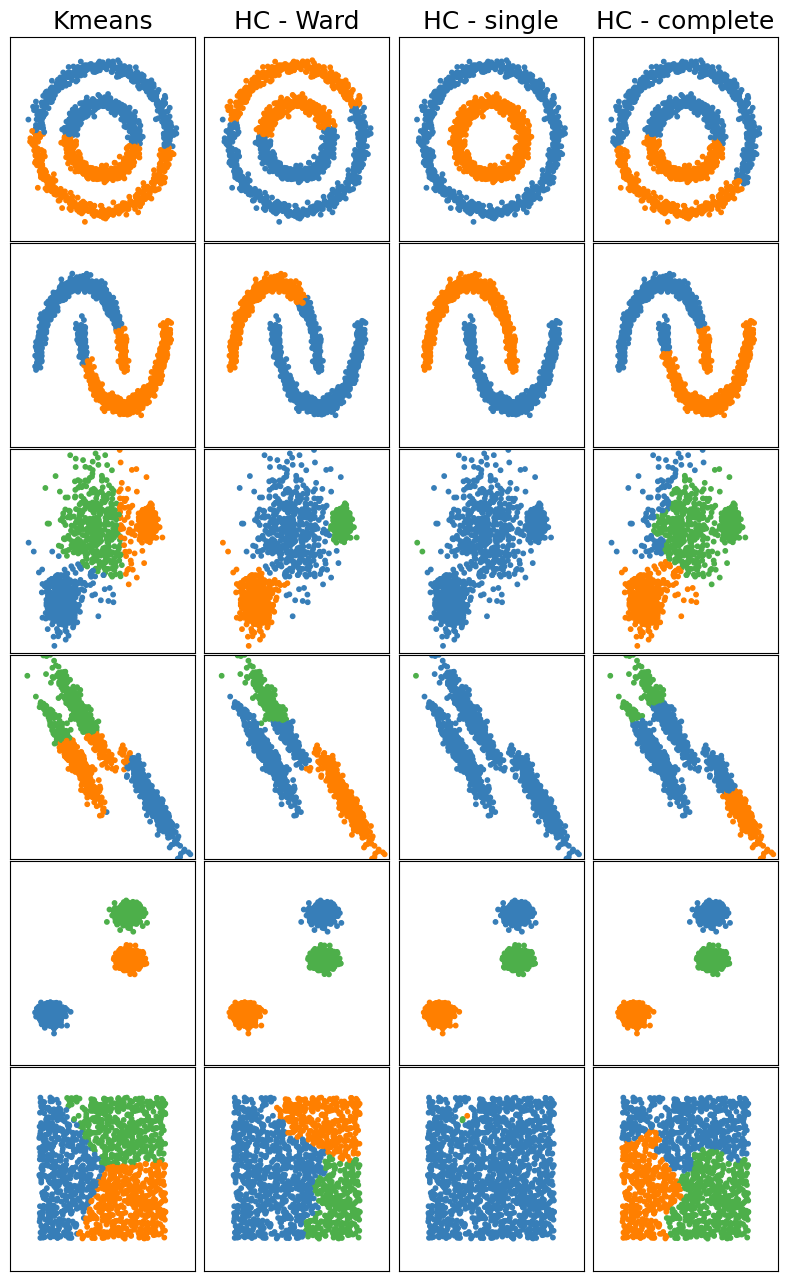

In [23]:
from sklearn import datasets

np.random.seed(1234)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============

datasets = [
    (noisy_circles, { 'n_clusters': 2 }),
    (noisy_moons, { 'n_clusters': 2 }),
    (varied, { 'n_clusters': 3 }),
    (aniso, { 'n_clusters': 3 }),
    (blobs, { 'n_clusters': 3 }),
    (no_structure, { 'n_clusters': 3 })]


plt.figure(figsize=(8, 13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1


for i_dataset, (dataset, params) in enumerate(datasets):

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    clustering_algorithms = [( 'Kmeans' , KMeans(n_clusters=params['n_clusters']) ),
                             ( 'HC - Ward' , AgglomerativeClustering(n_clusters=params['n_clusters'],
                                                                             linkage='ward') ),
                             ( 'HC - single' , AgglomerativeClustering(n_clusters=params['n_clusters'],
                                                                             linkage='single') ),
                             ( 'HC - complete' , AgglomerativeClustering(n_clusters=params['n_clusters'],
                                                                             linkage='complete') )]
    
    for name, algorithm in clustering_algorithms:
        
        algorithm.fit(X)
        y_pred = algorithm.labels_.astype(int)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(['#377eb8', '#ff7f00', '#4daf4a',
                           '#f781bf', '#a65628', '#984ea3',
                           '#999999', '#e41a1c', '#dede00'])[ :int(max(y_pred) + 1) ],
                                      
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())

        plot_num += 1


[Back to the ToC](#toc)


## Exercise: EDA and Clustering - single cell RNAseq data<a id="exo-kmeans-single"></a>

Data from: [Li H, Courtois ET, Sengupta D, Tan Y et al. Reference component analysis of single-cell transcriptomes elucidates cellular heterogeneity in human colorectal tumors. Nat Genet 2017 May;49(5):708-718. PMID: 28319088](https://pubmed.ncbi.nlm.nih.gov/28319088/)

The data consists in normalized expression data (log10 RPKM) of 561 cells from 7 different human cell lines.

For convenience, the cell lines have been associated to colors.

In the data table:

 * columns are genes
 * rows are cells
 
You can presume that the data has already been properly normalized, scaled, and imputed.
 
Instructions:

 1. perform a PCA and vizualize the results
 2. try to cluster the cells using K-Means or Hierarchical clustering. 
     Try several parameter values and evaluate your clustering with a metric.
 3. try the same thing, but use only the 50 first PCA components. Do you get better results?

In [24]:
## reading the data
X_rpkm = pd.read_csv("../data/GSE81861_log10_RPKM.csv.zip" , index_col=0)
X_rpkm.head()

,chrX:99883666-99894988_TSPAN6_ENSG00000000003.10,chrX:99839798-99854882_TNMD_ENSG00000000005.5,chr20:49505584-49575092_DPM1_ENSG00000000419.8,chr1:169631244-169863408_SCYL3_ENSG00000000457.9,chr1:169631244-169863408_C1orf112_ENSG00000000460.12,chr1:27938574-27961788_FGR_ENSG00000000938.8,chr1:196621007-196716634_CFH_ENSG00000000971.11,chr6:143771943-143832827_FUCA2_ENSG00000001036.9,chr6:53362138-53481969_GCLC_ENSG00000001084.6,chr6:40994771-41067715_NFYA_ENSG00000001167.10,...,chrY:2477388-2525270_LINC00102_ENSGR0000230542.1,chrY:1836239-1837669_RP13-297E16.5_ENSGR0000234622.1,chrY:1470661-1522655_ASMTL-AS1_ENSGR0000236017.3,chrY:1465319-1468295_LINC00106_ENSGR0000236871.2,chrY:900955-905100_RP11-309M23.1_ENSGR0000237531.1,chrY:59161253-59162245_AMDP1_ENSGR0000237801.1,chrY:1337692-1379274_BX649553.4_ENSGR0000264819.1,chrY:1387738-1388052_RN7SL355P_ENSGR0000265350.1,chrY:375315-375416_AL732314.1_ENSGR0000266731.1,chrY:59330251-59360854_AJ271736.10_ENSGR0000270726.1
RHA015__A549__turquoise,2.326991,-3.0,1.536602,-3.000000,-3.000000,-3.0,0.092610,1.775381,0.413535,2.203601,...,-3.0,-3.0,-3.0,-3.000000,-3.0,-3.000000,-3.0,0.883467,-3.000000,-3.0
RHA016__A549__turquoise,2.397589,-3.0,2.161102,1.338136,-0.627511,-3.0,1.790205,0.200586,1.639947,-3.000000,...,-3.0,-3.0,-3.0,0.585845,-3.0,-3.000000,-3.0,-3.000000,-3.000000,-3.0
RHA017__A549__turquoise,2.344598,-3.0,-3.000000,0.138558,-3.000000,-3.0,-3.000000,0.288192,2.087500,-3.000000,...,-3.0,-3.0,-3.0,-3.000000,-3.0,-3.000000,-3.0,0.940122,2.696217,-3.0
RHA018__A549__turquoise,2.044863,-3.0,2.446855,-3.000000,-3.000000,-3.0,1.389382,-3.000000,1.335080,-3.000000,...,-3.0,-3.0,-3.0,-3.000000,-3.0,-3.000000,-3.0,-3.000000,-3.000000,-3.0
RHA028__A549__turquoise,1.685791,-3.0,2.118460,0.770988,1.043914,-3.0,1.075204,-3.000000,1.866773,-3.000000,...,-3.0,-3.0,-3.0,-3.000000,-3.0,-0.128543,-3.0,-3.000000,-3.000000,-3.0


In [25]:
X_rpkm.shape ## 561 cells, 39900 genes

(561, 39900)

In [26]:
## creating a Serie associating each row to a single column
index_colors = pd.Series(X_rpkm.index).apply(lambda x : x.rpartition('_')[2])
index_colors.value_counts()

brown        165
orange       128
turquoise     74
blue          73
green         51
red           47
black         23
Name: count, dtype: int64

Solutions:

1. perform a PCA and vizualize the results

In [180]:
# %load -r 1-14 solutions/solution_01_GSE81861.py

fancier representation with 3D scatterplot

In [179]:
# %load -r 15-22 solutions/solution_01_GSE81861.py

2. try to cluster the cells using K-Means or Hierarchical clustering. 

first a single Kmean with K=7

In [185]:
# %load -r 23-37 solutions/solution_01_GSE81861.py

Try several parameter values and evaluate your clustering with a metric.

In [188]:
# %load -r 38-78 solutions/solution_01_GSE81861.py

plotting best clustering according to the Silhouette criterion

In [190]:
# %load -r 79-83 solutions/solution_01_GSE81861.py

 3. try the same thing, but use only the 50 first PCA components. Do you get better results?

In [192]:
# %load -r 84- solutions/solution_01_GSE81861.py

[Back to the ToC](#toc)


## Exercise: EDA and Clustering - mammals sleep <a id="exo-kmeans-mammals"></a>

Dataset from [Allison&Cicchetti 1976](https://science.sciencemag.org/content/194/4266/732)


* species: Species of animal
* bw : Body weight (kg)
* brw : Brain weight (g)
* sws : Slow wave ("nondreaming") sleep (hrs/day)
* ps : Paradoxical ("dreaming") sleep (hrs/day)
* ts : Total sleep (hrs/day) (sum of slow wave and paradoxical sleep)
* mls : Maximum life span (years)
* gt : Gestation time (days)
* pi : Predation index (1-5), 1 = least likely to be preyed upon
* sei : Sleep exposure index (1-5), 1 = least exposed (e.g. animal sleeps in a well-protected den), 5 = most exposed
* odi : Overall danger index (1-5) based on the above two indices and other information, 1 = least danger (from other animals), 5 = most danger (from other animals)

 1. handle the NAs. A mean imputation should work here (ie. replace NAs by their column average)
 2. perform a PCA. Plot the PCA projected data as well as the weight of each column on the axes. What can you say ?
 3. use t-SNE to get an embedding of the data in 2D and represent it.
     **bonus :** plot the species names in the embedded space with `plt.text`
 4. perform a Kmean, or hierarchical clustering on the PCA projected data. What is the best number of cluster according to the silhouette score?
 5. plot the t-SNE projected data colored according to the cluster they belong to.
 
 
**bonus**
 * try other clustering methods (eg, DBscan if you have done it with Kmeans before)
 * some variables could make more sense as a ratio, such as the brain weight / total body weight for instance. try to add some of these to the dataframe (or remove a couple of columns) and see how the results are affected.

In [27]:
df_mam = pd.read_csv('../data/mammalsleep.csv',sep=',', header=0 , index_col=0)

## some of these column make more sense as ratio
##df_mam["brain_ratio"] = df_mam.brw / df_mam.bw
##df_mam["ps_ratio"] = df_mam.ps / df_mam.ts

## dropping the now redundant columns
## df_mam.drop( columns = ["brw",'ps','sws'] , inplace=True )

df_mam.head()

,bw,brw,sws,ps,ts,mls,gt,pi,sei,odi
species,,,,,,,,,,
African elephant,6654.000,5712.0,NaN,NaN,3.3,38.6,645.0,3,5,3
African giant pouched rat,1.000,6.6,6.3,2.0,8.3,4.5,42.0,3,1,3
Arctic Fox,3.385,44.5,NaN,NaN,12.5,14.0,60.0,1,1,1
Arctic ground squirrel,0.920,5.7,NaN,NaN,16.5,NaN,25.0,5,2,3
Asian elephant,2547.000,4603.0,2.1,1.8,3.9,69.0,624.0,3,5,4


In [28]:
df_mam.isna().sum()

bw      0
brw     0
sws    14
ps     12
ts      4
mls     4
gt      4
pi      0
sei     0
odi     0
dtype: int64

In [29]:
df_mam.mean()

bw     198.789984
brw    283.134194
sws      8.672917
ps       1.972000
ts      10.532759
mls     19.877586
gt     142.353448
pi       2.870968
sei      2.419355
odi      2.612903
dtype: float64

Uncomment and execute to see the solution for each part of the exercise:

In [21]:
# %load -r 1-5 solutions/solution_01_kmean.py

In [19]:
# %load -r 7-42 solutions/solution_01_kmean.py

In [18]:
# %load -r 44-60 solutions/solution_01_kmean.py

In [17]:
# %load -r 62-81 solutions/solution_01_kmean.py

In [16]:
# %load -r 83- solutions/solution_01_kmean.py

# Appendix <a class="anchor" id="appendix-bullet"></a>

## DBSCAN <a class="anchor" id="DBSCAN-bullet"></a>

DBSCAN - **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise [Ester et al., Proc KDD, 1996](https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.121.9220) finds core points of high density and expands clusters from them. It works well for data which contains **clusters of similar density**. 

The algorithm starts by defining core points (points that are densely packed : at least `min_samples` points within a distance `eps` from each other). Then it expands a seed cluster $C_k$ by adding a point $p_j$ to the cluster if there a point $p_{l} \in C_k$ with $dist(p_j-p_{l})<\epsilon$. Points that cannot be linked to a seed cluster are marked as outliers.

![db](../images/db.png)


DBSCAN The average run time complexity of DBSCAN is $O(nlogn)$ (worst case $O(n^2)$), which makes attractive for large datasets.

First, we need to have an idea in which range $\epsilon$ will be:

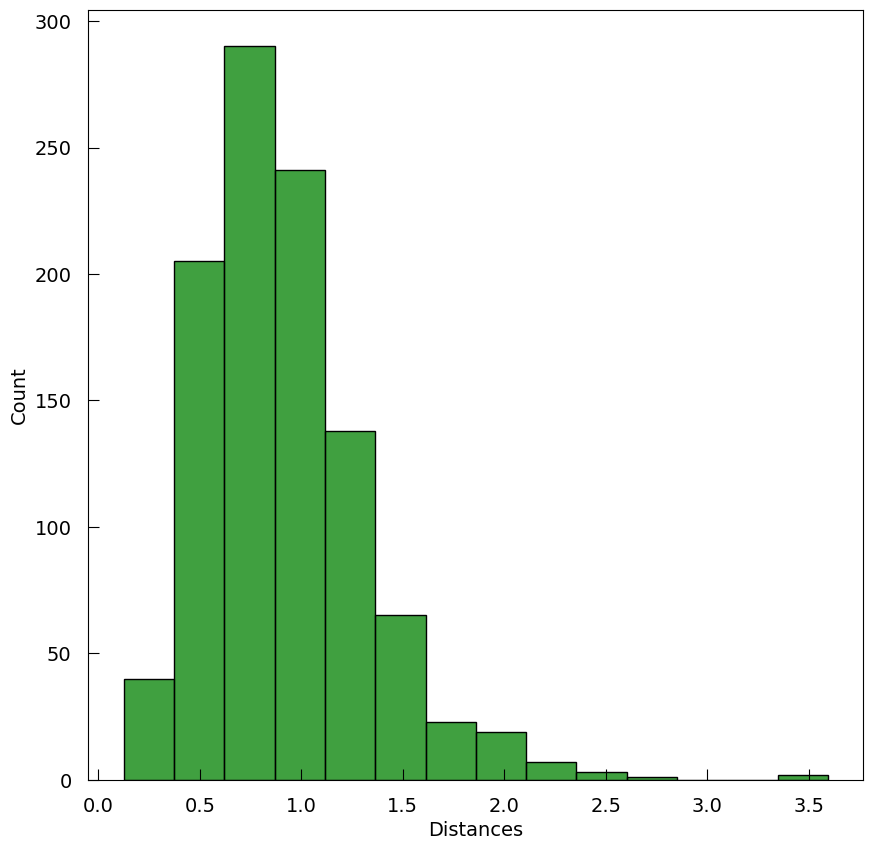

In [45]:
from sklearn.metrics import pairwise_distances

D = pd.DataFrame(pairwise_distances(X_im_pca, metric='euclidean'))
dists = D[D>0].min(axis=1) # get nearest neighbor distances

plt.figure(figsize=(10,10))
sns.histplot(dists, color="g", binwidth=0.25)
plt.xlabel("Distances")
plt.show()

So it looks like our epsilon would be somewhere between 0.25 and 2.

We will make our minimum number of samples vary from 5 to 25

In [47]:
%%time
from sklearn import cluster

eps = np.arange(0.10, 3, 0.10)
min_samples = np.arange(3,25,1)

## keep the scores in a 2D matrix, for each combination of eps and min_sample
scores = np.zeros( (len(eps) , len(min_samples)) )
N_assigned = np.zeros( (len(eps) , len(min_samples)) )

for i, e in enumerate( eps ):
    best_eps_score = -1
    for j, minS in enumerate( min_samples ):
        dbscan = cluster.DBSCAN(eps=e, min_samples=minS)
        dbscan.fit(X_im_pca)
        
        ## DBSCAN will detect some "outliers", which have a label of -1. We exclude them from the matric computation
        idx = dbscan.labels_ >= 0
        nr_clusters = len(np.unique(dbscan.labels_[idx]))
        
        N_assigned[i,j] = idx.sum()
        scores[i,j] = silhouette_score(X_im_pca[idx],dbscan.labels_[idx]) if nr_clusters > 1 else -1

CPU times: user 57.9 s, sys: 218 ms, total: 58.1 s
Wall time: 15.1 s


In [51]:
#now we grab the combination with the highest value
best_idx = np.unravel_index(scores.argmax(), scores.shape)
best_eps = eps[best_idx[0]]
best_min_samples = min_samples[best_idx[1]]

# and we perform the clustering with the best values:
dbscan = cluster.DBSCAN(eps=best_eps, min_samples=best_min_samples)
best_labels = dbscan.fit_predict(X_im_pca)


Text(0.5, 1.0, 'DBSCAN(eps=0.40, min_samples=3)')

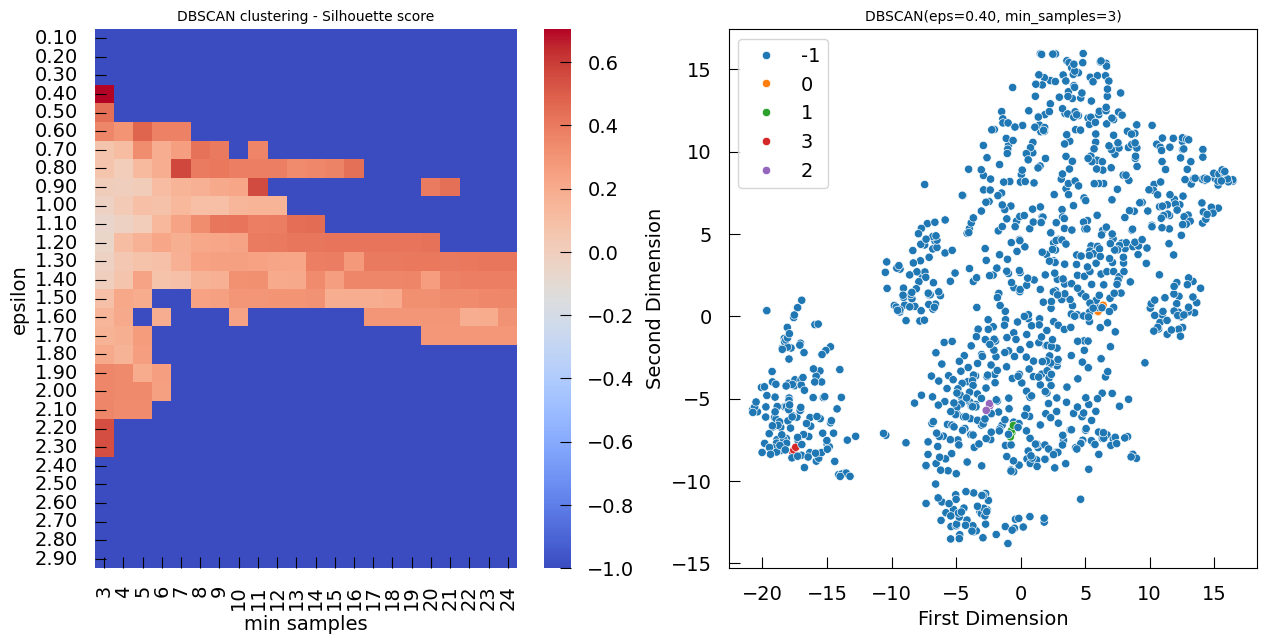

In [52]:
fig, axes = plt.subplots(1,2,figsize=(15,7))

sns.heatmap(scores,
            xticklabels=min_samples, 
            yticklabels=["{:.2f}".format(e) for e in eps],
            cmap='coolwarm' , ax = axes[0])
axes[0].set_ylabel('epsilon')
axes[0].set_xlabel('min samples')
axes[0].set_title('DBSCAN clustering - Silhouette score',fontsize=10)


sns.scatterplot(x=X_im_tsne.embedding_[:,0],y=X_im_tsne.embedding_[:,1],hue=best_labels.astype(str), ax=axes[1])
axes[1].set_xlabel('First Dimension')
axes[1].set_ylabel('Second Dimension')
axes[1].set_title('DBSCAN(eps={0:.2f}, min_samples={1})'.format(best_eps,best_min_samples),fontsize=10)

As you can see the solution with the highest silhouette score leaves a lot of points unclassified. 

This is something one has to be careful about with methods such as DBSCAN which have the option of leaving some points out, and can potentially be used to determine that this algorithm is not the most adapted to the nature of the data.

You can for example look at the number of points assigned to a cluster:

Text(0.5, 1.0, 'DBSCAN - number of points assigned to a cluster')

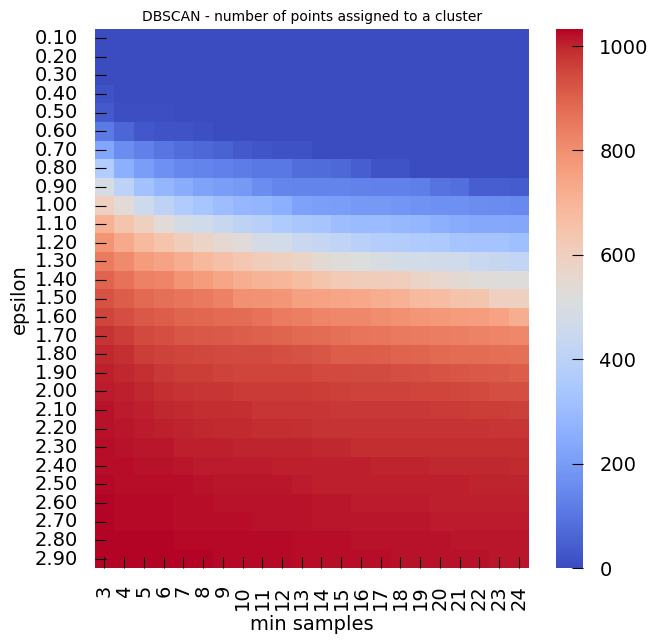

In [53]:
fig, axes = plt.subplots(1,1,figsize=(7,7))
sns.heatmap(N_assigned,
            xticklabels=min_samples, 
            yticklabels=["{:.2f}".format(e) for e in eps],
            cmap='coolwarm' , ax=axes )
axes.set_xlabel('min samples')
axes.set_ylabel('epsilon')
axes.set_title('DBSCAN - number of points assigned to a cluster'.format(best_eps,best_min_samples),fontsize=10)


**Question:** what other aspects could we look at to evaluate a clustering created by DBSCAN?

## Gaussian mixtures <a class="anchor" id="gm-bullet"></a>

In Gaussian mixture modeling [Fraley & Raftery, The Computer Journal, 1998](https://academic.oup.com/comjnl/article-abstract/41/8/578/360856) we represent the data $\pmb{X}$ as a mixture model normal probability distributions:

$p(\pmb{x}) = \sum_{i=1}^{K}\pi_iN(\pmb{x}|\pmb{\mu_i},\pmb{\Sigma}_i)$, 

where $N(\pmb{x}|\pmb{\mu},\pmb{\Sigma})$ is a multidimensional Gaussian distribution with mean $\pmb{\mu}$ and covariance matrix $\pmb{\Sigma}$. The method uses the expectation-maximization algorithm to find the mixture components $\pmb{\pi_i}$, $\pmb{\mu_i}$ and covariance matrix $\pmb{\Sigma}_i$.

The sklearn [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) class implements the algorithm. It allows you to specify the number of clusters ('n_components'), intitial values for the parameters and constrains on the covariance matrices $\pmb{\Sigma}_i$. 

A Bayesian version [BayesianGaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html#sklearn.mixture.BayesianGaussianMixture) uses priors for the mixture parameters.

In [ ]:
from sklearn import mixture
from sklearn.metrics import silhouette_score

nr_clusters = np.arange(9)+2

aic = []
best_score = np.inf
best_nr_clusters = 0
for n in nr_clusters:
    gmm = mixture.GaussianMixture(n)
    gmm.fit(X_im_scaled)
    score = gmm.bic(X_im_scaled)
    aic.append(score)

    if score < best_score:
        best_score = score
        best_nr_clusters = n
        best_gmm = gmm
        
best_labels = best_gmm.predict(X_im_scaled)

bgmm = mixture.BayesianGaussianMixture(n_components=10,
                                       covariance_type='full',
                                       weight_concentration_prior=0.01, max_iter=500)
bgmm.fit(X_im_scaled)
best_labels_bayes = bgmm.predict(X_im_scaled)
print(np.sort(bgmm.weights_))

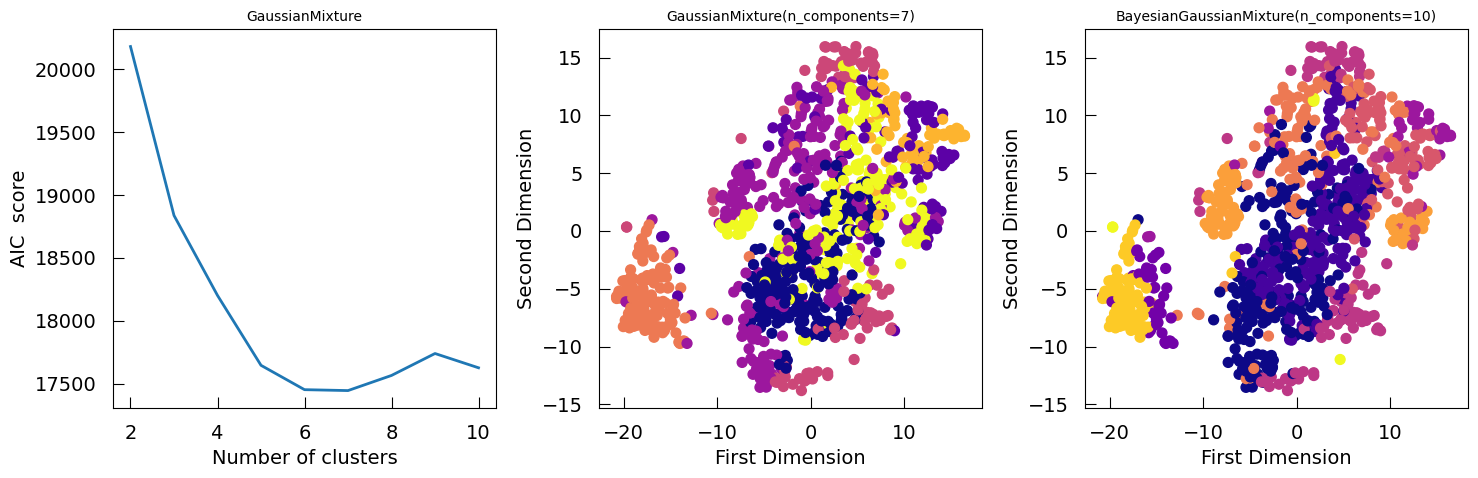

In [59]:
fig,ax = plt.subplots(1,3,figsize=(15,5))


ax[0].plot(nr_clusters, aic, ls="-", lw=2)
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('AIC  score')
ax[0].set_title('GaussianMixture',fontsize=10)


ax[1].scatter(X_im_tsne.embedding_[:,0],X_im_tsne.embedding_[:,1],c=best_labels,s=50,cmap='plasma')
ax[1].set_xlabel('First Dimension')
ax[1].set_ylabel('Second Dimension')
ax[1].set_title('GaussianMixture(n_components={0})'.format(best_nr_clusters),fontsize=10)


ax[2].scatter(X_im_tsne.embedding_[:,0],X_im_tsne.embedding_[:,1],c=best_labels_bayes,s=50,cmap='plasma')
ax[2].set_xlabel('First Dimension')
ax[2].set_ylabel('Second Dimension')
ax[2].set_title('BayesianGaussianMixture(n_components={0})'.format(10),fontsize=10)

fig.tight_layout()

# Additionnal exercise : Single cell dataset - preprocessing <a class="anchor" id="exo-bullet"></a>

In this exercice we will be playing with a single cell RNAseq dataset from [Li et al. 2017](https://www.nature.com/articles/ng.3818#Sec28).

In their article they evaluate several advanced clustering techniques specifically developped for RNAseq data.

In this exercise, we will be using the techniques we saw in this chapter, and also exploring the effect of normalization.

> Warning: this dataset is large, and present a no so easy clustering problem. Do not hesitate to take your time and test some of your code on a smaller subset of the data.


Let's start by reading the Count matrix


In [60]:
df = pd.read_csv('../data/GSE81861_Cell_Line_COUNT.csv', index_col=0)
df = df.loc[ df.sum(axis=1) != 0 , :] # we remove transcripts whose count is 0 in all cell
df.head()

,RHA015__A549__turquoise,RHA016__A549__turquoise,RHA017__A549__turquoise,RHA018__A549__turquoise,RHA028__A549__turquoise,RHA029__A549__turquoise,RHA030__A549__turquoise,RHA031__A549__turquoise,RHA032__A549__turquoise,RHA033__A549__turquoise,...,RHC2497__H1_B2__brown,RHC2498__H1_B2__brown,RHC2499__H1_B2__brown,RHC2500__H1_B2__brown,RHC2501__H1_B2__brown,RHC2502__H1_B2__brown,RHC2503__H1_B2__brown,RHC2504__H1_B2__brown,RHC2505__H1_B2__brown,RHC2506__H1_B2__brown
chrX:99883666-99894988_TSPAN6_ENSG00000000003.10,593.0,1049.000000,542.0,375.000,186.0,81.0,579.0,0.0,50.0,0.00000,...,823.0,881.0,824.0,324.0,1271.0,119.0,655.0000,355.0,422.0,770.0
chrX:99839798-99854882_TNMD_ENSG00000000005.5,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
chr20:49505584-49575092_DPM1_ENSG00000000419.8,33.0,209.000000,0.0,325.001,173.0,42.0,5.0,1.0,161.0,1.00001,...,56.0,449.0,147.0,32.0,29.0,491.0,146.0000,139.0,105.0,29.0
chr1:169631244-169863408_SCYL3_ENSG00000000457.9,0.0,190.001000,7.0,0.000,47.0,81.0,0.0,0.0,0.0,0.00000,...,12.0,46.0,31.0,4.0,4.0,80.0,95.9983,33.0,132.0,210.0
chr1:169631244-169863408_C1orf112_ENSG00000000460.12,0.0,0.999295,0.0,0.000,43.0,553.0,1.0,0.0,0.0,0.00000,...,117.0,415.0,286.0,3.0,35.0,709.0,10.0010,1.0,212.0,1037.0


In this matrix:
 - rows are transcripts
 - columns are cell
 - values correspond to the number of reads that were assigned to a given transcript in a given cell
 
Here, you can see that our samples (cells) are in columns, and our variables (transcripts) are in rows, which is the convention for RNAseq data, but not for `sklearn` machine learning routines, so you need to transpose this data:
 

In [61]:
X = df.transpose()

### tasks

We recommend you read all tasks and notes before starting to tackle this exercise.

#### A. normalization 

We will test the impact of normalization techniques on clustering. For this, create 2 versions of the dataset:
1. log10-transform the data with a pseudo-count of 1, then use the StandardScaler to scale the data
2. use the method of the paper : computing [RPKM](https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/) and filtering, following these steps:
    1. Count up the total reads in a sample and divide that number by 1,000,000 – this is our “per million” scaling factor.
    2. Divide the read counts by the “per million” scaling factor. This normalizes for sequencing depth, giving you reads per million (RPM)
    3. Divide the RPM values by the length of the gene, in kilobases, as found in the `../data/GSE81861_transcript_length.csv` file. This gives you RPKM.
    4. Keep only transcripts with a RPKM >= $10^{-3}$ in at least 2 cells
    5. log10-transform the data with a pseudo-count of $10^{-3}$
    
> NB: log-transforming X with a pseudocount of Y means: log(Y+X), this is done to avoid mathermatical errors whenthere are 0s in the data.

#### B. dimensionality reduction for visualization

3. Compute a PCA and a t-sne representation for each of the normalized dataset. Find appropriate values of the perplexity parameter for both (somewhere between 1 and 100).

#### C. hierarchical clustering 

For both normalized datasets:
4. try hierarchical clustering with "ward linkage, euclidean distance" and "average linkage, cosine distance", with  a number of clusters between 2 and 20, and measure the silhouette score each time.

> **Warning:** adapt the silhouette score to the metric distance you are currently using.

> **Warning2:** Hierarchical clustering on this data takes 2 to 5 seconds. With 2 normalizations options, 2 linkage/distance combinations, and 19 cluster numbers to evaluate, so 2*2*19=76 parameter combinations, running clustering for all parameter combinations can take around 3-6 minutes, so be sure to test your code on a smaller number of combinations firsts

5. What is the and parameter combinations (normalization technique, linkage, distance, and number of clusters) which gives the highest silhouette coefficient? 
6. Visualize the clusters given by this parameter combination on the relevant PCA and t-sne projection.

#### D. hierarchical clustering with an objective

In this experiment the cell actually belong to known cell types which are encoded in the cell names.

You can get the cell categories with the following code:
```{python}
cell_categories = pd.Series(df.columns).apply( lambda x : x.partition("_")[2].rpartition('_')[0].strip('_') )
```

They correspond to :
 - A549 : lung carcinoma
 - GM12878 : lymphoblastoid
 - H1437 : lung adenocarcinoma
 - IMR90 : fetal lung fibroblast
 - H1 : human embryonic stem cell
 - K562 : myelogenous leukemia

With some cell types presenting thecnical replicates (H1 for example).

Ideally, these cell types would correspond to clusters in the data, and the goal of the original study is to find which clustering method is able to find clusters which correspond as much as possible to the cell categories.

We will be doing something along these lines.

First, let's use what we already have:

7. compare the proposed clustering with the known categories of cells
8. looking at the silhouette score trajectories, and considering the known categories of cell, do you see sets of clustering parameters which may not have the best silhouette score but may be closer to the cell categories? check out that hypothesis.

To approach this problem in a more principled way, we will use a score which compare two clustering : the adjusted rand index, computed using the [adjusted_rand_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) sklearn function.



9. Compute the adjusted random index to choose the normalization method and clustering parameters which resemble the cell categories the best
10. Represent the best clustering according to the adjusted rand index
11. What do yo think about this shift in perspective?

> If you have read this until the end before performing all the computations, then you can see that during step 4 you could also record the adjusted rand index alongside the silhouette score, so that you don't have to perform the long computations again for question 9